# 1. Imports and Funcions

In [11]:
# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession

# Create a Session
spark = SparkSession.builder.appName('AnalyzerApp').master('spark://172.31.19.209:7077').getOrCreate()

## 1.1. Imports

In [49]:
import sys
from pyspark.sql.types import *
from pyspark.sql import Row, DataFrame, functions as F
from datetime import datetime, date, timedelta
from pyspark.sql.window import Window

In [50]:
import pandas as pd
import numpy as np
#PySpark ML
import warnings
warnings.filterwarnings('ignore')
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import types
from pandas import Series, DataFrame
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)
plt.rcParams['figure.figsize'] = (11, 7)

***With the next lines of code every time we perform an action with a show function, it doesnt matter how big is the dataframe or how many columns does it have, it will print the table like a pandas table without the need of conversion and the posibility of running out of memory.***

In [51]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

## 1.2. Functions

In [52]:
def parse_closing_date(closing_date_str):
    closing_date = datetime.strptime(closing_date_str, '%m/%d/%Y').date()
    return closing_date

In [53]:
def parse_closing_date1(closing_date_str):
    closing_date = datetime.strptime(closing_date_str, '%m/%Y').date()
    return closing_date

# 2. Variables

***Dataframe Path***

In [15]:
df_acquisitions = 'hdfs://hdfs:9000/tfm/Dataframes/SingleFamily/SingleFamilyFixedRateMortgage/Acquisition/'
df_performance = 'hdfs://hdfs:9000/tfm/Dataframes/SingleFamily/SingleFamilyFixedRateMortgage/Performance/'
temp_acquisitions = 'hdfs://hdfs:9000/tfm//Dataframes/SingleFamily/temp/acquisitions/sandbox/'
temp_performance = 'hdfs://hdfs:9000/tfm/Dataframes/SingleFamily/temp/performance/sandbox/'
temp_combined = 'hdfs://hdfs:9000/tfm/Dataframes/SingleFamily/temp/combined/sandbox/'

# 3. Manage Data

## 3.1. Acquisitions File

## 3.1.1. Read Data

In [55]:
acquisitions = spark.read.parquet(df_acquisitions)

In [56]:
acquisitions.show()

+------------+--------+--------------------+-------+--------+--------+--------+--------+----+-----+------+---+--------+--------+-------+--------+--------+--------+-----+-----+------+------------+--------+-------+--------------+
|     LOAN_ID|ORIG_CHN|         Seller_Name|ORIG_RT|ORIG_AMT|ORIG_TRM|ORIG_DTE|FRST_DTE|OLTV|OCLTV|NUM_BO|DTI|CSCORE_B|FTHB_FLG|PURPOSE|PROP_TYP|NUM_UNIT|OCC_STAT|STATE|ZIP_3|MI_PCT|Product_Type|CSCORE_C|MI_TYPE|RELOCATION_FLG|
+------------+--------+--------------------+-------+--------+--------+--------+--------+----+-----+------+---+--------+--------+-------+--------+--------+--------+-----+-----+------+------------+--------+-------+--------------+
|100000827160|       R|               OTHER|   4.25|  150000|     360| 03/2016| 05/2016|  49|   49|     2| 27|     809|       N|      C|      SF|       1|       I|   CA|  953|  null|         FRM|     812|   null|             N|
|100002112463|       R|               OTHER|  4.625|  250000|     360| 04/2016| 06/2016|

## 3.1.2. Manage Data

***First, I am going to delete the unnecessary Acquisition variables from the dataframe***

In [57]:
acquisitions = acquisitions.drop('Seller_Name', 'Product_Type')

***Calculation of the minimum FICO score by comparing the borrower credit score vs the coborrower credit score***

In [58]:
acquisitions = acquisitions.where(~((F.col('CSCORE_B').isNull()) & (F.col('CSCORE_C').isNull())))

In [59]:
acquisitions = acquisitions.withColumn('CSCORE_MN', F.when(F.col('CSCORE_B').isNull(), F.col('CSCORE_C'))\
                          .otherwise(F.when(F.col('CSCORE_C').isNull(), F.col('CSCORE_B'))\
                          .otherwise(F.when(F.col('CSCORE_C') < F.col('CSCORE_B'), F.col('CSCORE_C'))\
                          .otherwise(F.when(F.col('CSCORE_B') < F.col('CSCORE_C'), F.col('CSCORE_B')).otherwise(F.col('CSCORE_B'))))))

In [60]:
acquisitions = acquisitions.withColumn('CSCORE_B', F.when(F.col('CSCORE_B').isNull(), F.col('CSCORE_C')).otherwise(F.col('CSCORE_B')))\
                           .withColumn('CSCORE_C', F.when(F.col('CSCORE_C').isNull(), F.col('CSCORE_B')).otherwise(F.col('CSCORE_C')))

***Calculation of the House Price***

In [61]:
acquisitions = acquisitions.withColumn('ORIG_VAL', F.lit(F.round(F.col('ORIG_AMT')/(F.col('OLTV')/100),1)))

***Replacement of missing OCLTV with OLTV values***

In [62]:
acquisitions = acquisitions.withColumn('OCLTV', F.when(F.col('OCLTV').isNull(), F.col('OLTV')).otherwise(F.col('OCLTV')))

## 3.2. Performance File

## 3.2.1. Read Data

In [63]:
performance = spark.read.parquet(df_performance)

In [64]:
performance.show()

+------------+---------------+-------------+-------+--------+--------+-------------------+----------------+-------------+-----+-----------+--------+-------------+------+-------+-------+-------+--------+-------+-------+-------+--------+--------+--------+---------+-------+-----------+------------------+----------+-----------------+------------+
|     LOAN_ID|Monthly_Rpt_Prd|Servicer_Name|LAST_RT|LAST_UPB|Loan_Age|Months_To_Legal_Mat|Adj_Month_To_Mat|Maturity_Date|  MSA|Delq_Status|MOD_FLAG|Zero_Bal_Code|ZB_DTE|LPI_DTE|FCC_DTE|DISP_DT|FCC_COST|PP_COST|AR_COST|IE_COST|TAX_COST|NS_PROCS|CE_PROCS|RMW_PROCS|O_PROCS|NON_INT_UPB|PRIN_FORG_UPB_FHFA|REPCH_FLAG|PRIN_FORG_UPB_OTH|TRANSFER_FLG|
+------------+---------------+-------------+-------+--------+--------+-------------------+----------------+-------------+-----+-----------+--------+-------------+------+-------+-------+-------+--------+-------+-------+-------+--------+--------+--------+---------+-------+-----------+------------------+--------

In [65]:
performance.count()

298507297

## 3.2.2. Manage Data

***First, we order the data by Loan ID and Monthly Reporting Period***

In [66]:
performance = performance.orderBy('LOAN_ID', F.substring(F.col('Monthly_Rpt_Prd'),7,4), F.substring(F.col('Monthly_Rpt_Prd'),1,2), F.substring(F.col('Monthly_Rpt_Prd'),4,2))

***Calculation of the total of principle forgiveness UPB***

In [67]:
performance = performance.withColumn('PRIN_FORG_UPB_OTH', F.col('PRIN_FORG_UPB_OTH').cast('double'))

In [68]:
performance = performance.fillna(0.0, ['PRIN_FORG_UPB_FHFA', 'PRIN_FORG_UPB_OTH'])

In [69]:
performance = performance.withColumn('PRIN_FORG_UPB', F.col('PRIN_FORG_UPB_FHFA') + F.col('PRIN_FORG_UPB_OTH')).drop('PRIN_FORG_UPB_FHFA', 'PRIN_FORG_UPB_OTH')

***Calculation of the Standarize Delinquenzy Status Codes***

In [70]:
performance = performance.withColumn('Delq_Status', F.when(F.col('Delq_Status') == 'X', '999').otherwise(F.col('Delq_Status')))

***Now we add the original rate from the Acquisitions File***

In [71]:
performance = performance.join(acquisitions.select('LOAN_ID', 'ORIG_RT'), 'LOAN_ID', 'left')

***Now we need to apply a function to fill current UPBs and NON_INT_UPBs***

In [72]:
performance = performance.withColumn("LAST_UPB", F.first('LAST_UPB', True).over(Window.partitionBy('LOAN_ID')\
.orderBy(F.substring(F.col('Monthly_Rpt_Prd'),7,4), F.substring(F.col('Monthly_Rpt_Prd'),1,2), F.substring(F.col('Monthly_Rpt_Prd'),4,2)).rowsBetween(0,sys.maxsize)))\
            .fillna(0.0, 'LAST_UPB')

In [73]:
performance = performance.withColumn("NON_INT_UPB", F.first('NON_INT_UPB', True).over(Window.partitionBy('LOAN_ID')\
.orderBy(F.substring(F.col('Monthly_Rpt_Prd'),7,4), F.substring(F.col('Monthly_Rpt_Prd'),1,2), F.substring(F.col('Monthly_Rpt_Prd'),4,2)).rowsBetween(0,sys.maxsize)))\
            .fillna(0.0, 'NON_INT_UPB')

***Persist in order to gain performance***

In [74]:
performance.write.parquet(temp_performance + '/1/', mode = 'overwrite')

In [75]:
performance = spark.read.parquet(temp_performance + '/1/')

In [76]:
performance_grouped = performance.withColumn('MAT_UNIQUE', F.dense_rank().over(Window.partitionBy('LOAN_ID').orderBy('Maturity_Date')))\
                .groupBy('LOAN_ID', 'Maturity_Date').agg(F.sum('MAT_UNIQUE').alias('MAT_UNIQUE'))\
                        .withColumn('MODTRM_CHNG', F.when(F.col('MAT_UNIQUE') == 1, 1).otherwise(0))

In [77]:
performance = performance.join(performance_grouped.select('LOAN_ID', 'Maturity_Date', 'MODTRM_CHNG'), ['LOAN_ID', 'Maturity_Date'], 'left')

In [78]:
performance = performance.withColumn('NON_INT_UPB', F.col('NON_INT_UPB')*(-1))\
            .withColumn('NON_INT_UPB', F.when(F.col('NON_INT_UPB') == -0.0, F.lit(0.0)).otherwise(F.col('NON_INT_UPB')))

In [79]:
performance = performance.withColumn('PRIN_FORG_UPB', F.col('PRIN_FORG_UPB')*(-1))

In [80]:
performance = performance.withColumn('PREVIOUS_UPB', F.lag('LAST_UPB').over(Window.partitionBy('LOAN_ID')\
                                        .orderBy(F.substring(F.col('Monthly_Rpt_Prd'),7,4), F.substring(F.col('Monthly_Rpt_Prd'),1,2), F.substring(F.col('Monthly_Rpt_Prd'),4,2))))\
                         .withColumn('MODUPB_CHNG', F.when((F.col('LAST_UPB') > F.col('PREVIOUS_UPB')) & (F.col('MOD_FLAG') == 'Y'), F.lit(1)).otherwise(0)).drop('PREVIOUS_UPB')

In [81]:
performance = performance.withColumn('FIN_UPB', F.col('LAST_UPB') + F.col('NON_INT_UPB') + F.col('PRIN_FORG_UPB'))

In [82]:
performance = performance.withColumn('modir_cost', F.when(F.col('MOD_FLAG') == 'Y', F.lit(F.round(((F.col('ORIG_RT')-F.col('LAST_RT'))/1200)*F.col('LAST_UPB'), 2))).otherwise(F.lit(0)))

In [83]:
performance = performance.withColumn('modfb_cost', F.when(F.col('MOD_FLAG') == 'Y', F.lit(F.round(((F.col('LAST_RT')*(-1))/1200)*F.col('NON_INT_UPB'), 2))).otherwise(F.lit(0)))

In [84]:
performance = performance.withColumn('modfg_cost', F.when((F.col('PRIN_FORG_UPB') > 0), F.col('PRIN_FORG_UPB')*(-1)).otherwise(F.lit(0*(-1))))

In [85]:
performance = performance.withColumn('c_modir_cost', F.round(F.sum('modir_cost').over(Window.partitionBy('LOAN_ID')\
                            .orderBy(F.substring(F.col('Monthly_Rpt_Prd'),7,4), F.substring(F.col('Monthly_Rpt_Prd'),1,2), F.substring(F.col('Monthly_Rpt_Prd'),4,2))\
                              .rangeBetween(Window.unboundedPreceding, 0)), 2))

In [86]:
performance = performance.withColumn('c_modfb_cost', F.round(F.sum('modfb_cost').over(Window.partitionBy('LOAN_ID')\
                            .orderBy(F.substring(F.col('Monthly_Rpt_Prd'),7,4), F.substring(F.col('Monthly_Rpt_Prd'),1,2), F.substring(F.col('Monthly_Rpt_Prd'),4,2))\
                              .rangeBetween(Window.unboundedPreceding, 0)), 2))

***Persist in order to gain performance***

In [87]:
performance.write.parquet(temp_performance + '/2/', mode = 'overwrite')

In [88]:
performance = spark.read.parquet(temp_performance + '/2/')

***Now we are going to count the number of months a LOAN is active***

In [89]:
performance_grouped = performance.groupBy('LOAN_ID').agg(F.count(F.substring(F.col('Monthly_Rpt_Prd'),1,2)).alias('Count'))

In [90]:
performance = performance.join(performance_grouped.select('LOAN_ID', 'Count'), ['LOAN_ID'], 'left')

***Obtain the date of the first time each loan was modified***

In [91]:
performance = performance.withColumn('FMOD_DTE', F.lit(F.first('Monthly_Rpt_Prd').over(Window.partitionBy('LOAN_ID')\
        .orderBy(F.desc('MOD_FLAG')))))\
                         .withColumn('FMOD_UPB', F.lit(F.first('LAST_UPB').over(Window.partitionBy('LOAN_ID')\
        .orderBy(F.desc('MOD_FLAG')))))

***Obtain the date and UPB of each loan's first credit event***

In [92]:
performance = performance.withColumn('x', F.when((F.col('Zero_Bal_Code') == '03') | 
                                                  (F.col('Zero_Bal_Code') == '09') |
                                                  ((F.col('Delq_Status') < 999) &
                                                   (F.col('Delq_Status') >= 6)), F.lit(1)).otherwise(0))\
                    .withColumn('FCE_DTE',F.lit(F.first('Monthly_Rpt_Prd').over(Window.partitionBy('LOAN_ID').orderBy(F.desc('x')))))\
                    .withColumn('FCE_UPB',F.lit(F.first('LAST_UPB').over(Window.partitionBy('LOAN_ID').orderBy(F.desc('x')))))\
                    .withColumn('SPDelq1',F.lit(F.first('Delq_Status').over(Window.partitionBy('LOAN_ID').orderBy(F.desc('x')))))\
                    .withColumn('CountFC',F.lit(F.first('Count').over(Window.partitionBy('LOAN_ID').orderBy(F.desc('x'))))).drop('x')
    

***Obtain the date and UPB of each loan's becoming 180 days delinquent***

In [93]:
performance = performance.withColumn('x', F.when(((F.col('Delq_Status') < 999) &
                                                   (F.col('Delq_Status') >= 6)), F.lit(1)).otherwise(0))\
                    .withColumn('F180_DTE',F.lit(F.first('Monthly_Rpt_Prd').over(Window.partitionBy('LOAN_ID').orderBy(F.desc('x')))))\
                    .withColumn('F180_UPB',F.lit(F.first('LAST_UPB').over(Window.partitionBy('LOAN_ID').orderBy(F.desc('x')))))\
                    .withColumn('SPDelq2',F.lit(F.first('Delq_Status').over(Window.partitionBy('LOAN_ID').orderBy(F.desc('x')))))\
                    .withColumn('CountF1',F.lit(F.first('Count').over(Window.partitionBy('LOAN_ID').orderBy(F.desc('x'))))).drop('x')
    

***Define the last status of a loan***

In [94]:
performance = performance.withColumn('LAST_STAT', F.when(F.col('Zero_Bal_Code') == '01', F.lit('P'))\
                              .otherwise(F.when(F.col('Zero_Bal_Code') == '02', F.lit('T'))\
                              .otherwise(F.when(F.col('Zero_Bal_Code') == '03', F.lit('S'))\
                              .otherwise(F.when(F.col('Zero_Bal_Code') == '06', F.lit('R'))\
                              .otherwise(F.when(F.col('Zero_Bal_Code') == '09', F.lit('F'))\
                              .otherwise(F.when(F.col('Zero_Bal_Code') == '15', F.lit('N'))\
                              .otherwise(F.when(F.col('Zero_Bal_Code') == '16', F.lit('L'))\
                              .otherwise(F.when(F.col('Delq_Status') == '999', F.lit('X'))\
                              .otherwise(F.when(F.col('Delq_Status') > 9, F.lit('9'))\
                              .otherwise(F.when(F.col('Delq_Status') == 0, F.lit('C')).otherwise(F.col('Delq_Status'))))))))))))

In [95]:
performance.write.parquet(temp_performance + '/3/', mode = 'overwrite')

In [96]:
performance = spark.read.parquet(temp_performance + '/3/')

***Now we summarize the performance dataset by keeping the last row of a loan's activity***

In [97]:
performance_last = performance.withColumn('last', F.lit(F.last('Monthly_Rpt_Prd').over(Window.partitionBy('LOAN_ID'))))\
                                .where(F.col('Monthly_Rpt_Prd') == F.col('last')).drop('last')

***Persist in order to gain performance***

In [98]:
performance_last.count()

9366882

In [99]:
udf_date = F.udf(lambda x: parse_closing_date(x), DateType())

In [100]:
udf_date1 = F.udf(lambda x: parse_closing_date1(x), DateType())

In [101]:
performance_last = performance_last.fillna('01/01/9999', ['LPI_DTE', 'FCC_DTE', 'DISP_DT']).fillna('01/9999', ['ZB_DTE'])\
                         .withColumn('DISP_DT', udf_date(F.col('DISP_DT')))\
                         .withColumn('LPI_DTE', udf_date(F.col('LPI_DTE')))\
                         .withColumn('FCC_DTE', udf_date(F.col('FCC_DTE')))\
                         .withColumn('ZB_DTE', udf_date1(F.col('ZB_DTE')))\
                         .withColumn('Monthly_Rpt_Prd', udf_date(F.col('Monthly_Rpt_Prd')))

***Calculate the months between Last Paid Installment and Disposition date (for Lost Interest Calculation)***

In [102]:
performance_last = performance_last.withColumn('lpi2disp', F.months_between(F.col('DISP_DT'), F.col('LPI_DTE')).cast('integer'))\
                                   .withColumn('lpi2disp', F.when(F.col('lpi2disp') < 0, F.col('lpi2disp')*(-1))\
                                                .otherwise(F.when(F.col('lpi2disp') > 100, F.lit('Nulo'))))\
                                   .withColumn('zb2disp', F.months_between(F.col('DISP_DT'), F.col('ZB_DTE')).cast('integer'))\
                                   .withColumn('zb2disp', F.when(F.col('zb2disp') < 0, F.col('zb2disp')*(-1))\
                                                .otherwise(F.when((F.col('zb2disp') > 100) |
                                                                  (F.col('zb2disp').isNull()), F.lit('Nulo')).otherwise(F.col('zb2disp'))))

In [103]:
performance_last.write.parquet(temp_performance + '/4/', mode = 'overwrite')

In [104]:
performance_last = spark.read.parquet(temp_performance + '/4/')

***Calculate Interest Cost, total expenses and total proceeds***

In [105]:
performance_last = performance_last.withColumn('INT_COST', F.lit(F.col('FIN_UPB')*(((F.col('LAST_RT')/100) - 0.0035)/12)*F.col('lpi2disp')))\
                                   .withColumn('INT_COST', F.when(F.col('INT_COST') < 0, F.lit(0)).otherwise(F.col('INT_COST')))

In [106]:
performance_last = performance_last.fillna(0.0, ['PP_COST', 
                                            'AR_COST', 
                                            'TAX_COST',
                                            'FCC_COST',
                                            'IE_COST']).withColumn('total_expense', F.col('FCC_COST') + 
                                                                                   F.col('PP_COST') + 
                                                                                   F.col('AR_COST') + 
                                                                                   F.col('TAX_COST') + 
                                                                                   F.col('IE_COST'))

In [107]:
performance_last = performance_last.fillna(0.0, ['NS_PROCS', 
                                                 'CE_PROCS', 
                                                 'RMW_PROCS',
                                                 'O_PROCS']).withColumn('total_proceeds', ((F.col('NS_PROCS') + 
                                                                                             F.col('CE_PROCS') + 
                                                                                             F.col('RMW_PROCS') + 
                                                                                             F.col('O_PROCS'))*(-1)))

***Calculate the Net Loss, Net Severity, Total Costs, Total Proceeds and Liquidation Expenses. Define Last Date variable***

In [108]:
performance_last = performance_last.fillna(0.0, ['LAST_UPB', 
                                                 'INT_COST', 
                                                 'total_expense',
                                                 'total_proceeds']).withColumn('NET_LOSS', F.lit(F.col('LAST_UPB') + 
                                                                                                 F.col('INT_COST') + 
                                                                                                 F.col('total_expense') + 
                                                                                                 F.col('total_proceeds')))

In [109]:
performance_last = performance_last.fillna(0.0, ['LAST_UPB', 
                                                 'INT_COST', 
                                                 'total_expense',
                                                 'total_proceeds']).withColumn('NET_SEV',F.lit((F.col('LAST_UPB') + 
                                                                                             F.col('INT_COST') + 
                                                                                             F.col('total_expense') + 
                                                                                             F.col('total_proceeds'))/F.col('LAST_UPB'))).fillna(0.0, ['NET_SEV'])

In [110]:
performance_last = performance_last.fillna(0.0, ['LAST_UPB', 
                                                 'INT_COST', 
                                                 'FCC_COST',
                                                 'PP_COST',
                                                 'AR_COST',
                                                 'IE_COST',
                                                 'TAX_COST']).withColumn('Total_Cost', F.lit(F.col('LAST_UPB') + 
                                                                                             F.col('INT_COST') + 
                                                                                             F.col('FCC_COST') + 
                                                                                             F.col('PP_COST') + 
                                                                                             F.col('AR_COST') + 
                                                                                             F.col('IE_COST') + 
                                                                                             F.col('TAX_COST')))

In [111]:
performance_last = performance_last.fillna(0.0, ['NS_PROCS', 
                                                 'CE_PROCS', 
                                                 'RMW_PROCS',
                                                 'O_PROCS']).withColumn('Tot_Procs', F.lit(F.col('NS_PROCS') + 
                                                                                         F.col('CE_PROCS') + 
                                                                                         F.col('RMW_PROCS') + 
                                                                                         F.col('O_PROCS')))

In [112]:
performance_last = performance_last.fillna(0.0, ['FCC_COST', 
                                                 'PP_COST', 
                                                 'AR_COST',
                                                 'IE_COST',
                                                 'TAX_COST']).withColumn('Tot_Liq_Ex', F.lit(F.col('FCC_COST') + 
                                                                                     F.col('PP_COST') + 
                                                                                     F.col('AR_COST') + 
                                                                                     F.col('IE_COST') + 
                                                                                     F.col('TAX_COST')))

In [113]:
performance_last = performance_last.withColumn('LAST_DTE', F.col('DISP_DT'))

In [114]:
performance = performance_last.drop('Count', 
                               'Monthly_Rpt_Prd', 
                               'ZB_DTE', 
                               'ORIG_RT', 
                               'Servicer_Name', 
                               'Loan_Age', 
                               'Months_To_Legal_Mat', 
                               'Adj_Month_To_Mat', 
                               'Maturity_Date', 
                               'Delq_Status', 
                               'total_expense', 
                               'total_proceeds', 
                               'lpi2disp')

***Merge together full Acquisitions and Performance Data***

In [115]:
combined_data = acquisitions.join(performance, 'LOAN_ID', 'full')

In [116]:
combined_data.write.parquet(temp_combined, mode = 'overwrite')

In [117]:
combined_data = spark.read.parquet(temp_combined)

In [118]:
combined_data.count()

9366884

***Create Vintage Year and Activity Year Attributes, set missing F180_UPB and FCE_UPB equal to ORIG_AMT if the loan goes to delinquency during first six month of loan activity***

In [119]:
combined_data = combined_data.withColumn('VinYr', F.substring(F.col('ORIG_DTE'), 4, 4))\
                             .withColumn('ActYr', F.year(F.col('LAST_DTE'))) \
                             .withColumn('DispYr', F.when(F.col('DISP_DT').isNotNull(), F.substring(F.col('DISP_DT'), 1, 4)).otherwise(F.lit('NO_DISP_DT')))

In [120]:
combined_data = combined_data.withColumn('F180_UPB', F.when((F.col('SPDelq2') == 6) &
                                                            (F.col('CountF1') <= 6) &
                                                            ((F.col('F180_UPB') == 0) |
                                                             (F.col('F180_UPB').isNull())), F.col('ORIG_AMT'))\
                                          .otherwise(F.when((F.col('F180_UPB').isNotNull()), F.col('F180_UPB')).otherwise(F.lit(0))))

In [121]:
combined_data = combined_data.withColumn('FCE_UPB', F.when((F.col('SPDelq1') == 6) &
                                                           (F.col('CountFC') <= 6) &
                                                           ((F.col('FCE_UPB') == 0) |
                                                            (F.col('FCE_UPB').isNull())), F.col('ORIG_AMT'))\
                                         .otherwise(F.when((F.col('FCE_UPB').isNotNull()), F.col('FCE_UPB')).otherwise(F.lit(0))))

***Calculate Modification Costs when loans default***

In [122]:
combined_data = combined_data.withColumn('MODIR_COST', F.when((F.col('MOD_FLAG') == 'Y') &
                                              (F.col('DISP_DT').isNotNull()), 
                                               F.lit((F.col('zb2disp')*((F.col('ORIG_RT') - F.col('LAST_RT'))/1200)*F.col('LAST_UPB')) + F.col('c_modir_cost'))).otherwise(F.lit(0)))\
                             .withColumn('MODFB_COST', F.when((F.col('MOD_FLAG') == 'Y') &
                                              ((F.col('NON_INT_UPB').isNotNull()) |
                                               (F.col('NON_INT_UPB') == 0)), 
                                               F.lit((F.col('zb2disp')*(F.col('LAST_RT')/1200)*((-1)*(F.col('NON_INT_UPB')))) + F.col('c_modfb_cost'))).otherwise(F.lit(0)))

In [123]:
combined_data = combined_data.withColumn('MODTOT_COST', F.col('modfg_cost') +
                                                        F.col('MODIR_COST') +
                                                        F.col('MODFB_COST'))

In [124]:
combined_data = combined_data.drop('SPDelq1',
                                   'SPDelq2',
                                   'CountF1',
                                   'CountFC',
                                   'modfg_cost',
                                   'modir_cost')

***Drop Loans whose Origination Process is not defined***

In [125]:
combined_data = combined_data.where(F.col('ORIG_CHN').isNotNull())

In [126]:
combined_data.write.parquet(temp_combined + '/1/', mode = 'overwrite')

In [9]:
combined_data = spark.read.parquet(temp_combined + '/1/')

# 4. Analyzer

In [10]:
combined_data.show()

+------------+--------+-------+--------+--------+--------+--------+----+-----+------+---+--------+--------+-------+--------+--------+--------+-----+-----+------+--------+-------+--------------+---------+--------+-------+---------+-----+--------+-------------+----------+----------+----------+--------+-------+-------+-------+--------+--------+--------+---------+-------+-----------+----------+------------+-------------+-----------+-----------+---------+----------+------------+------------+----------+---------+----------+---------+----------+---------+---------+-------+--------+---------+-------+----------+---------+----------+----------+-----+-----+------+----------+----------+-----------+
|     LOAN_ID|ORIG_CHN|ORIG_RT|ORIG_AMT|ORIG_TRM|ORIG_DTE|FRST_DTE|OLTV|OCLTV|NUM_BO|DTI|CSCORE_B|FTHB_FLG|PURPOSE|PROP_TYP|NUM_UNIT|OCC_STAT|STATE|ZIP_3|MI_PCT|CSCORE_C|MI_TYPE|RELOCATION_FLG|CSCORE_MN|ORIG_VAL|LAST_RT| LAST_UPB|  MSA|MOD_FLAG|Zero_Bal_Code|   LPI_DTE|   FCC_DTE|   DISP_DT|FCC_COST|PP_

## 4.1. NULL Treatment

In [11]:
combined_data.agg(*[F.count(F.when(F.isnull(c),c)).alias(c) for c in combined_data.columns if combined_data.where(F.col(c).isNull()).count() > 0]).toPandas().head()

,DTI,MI_PCT,MI_TYPE,LAST_RT,LAST_UPB,MSA,MOD_FLAG,Zero_Bal_Code,LPI_DTE,FCC_DTE,...,zb2disp,INT_COST,NET_LOSS,NET_SEV,Total_Cost,Tot_Procs,Tot_Liq_Ex,LAST_DTE,ActYr,MODTOT_COST
0,1976,6696295,6696295,2,2,2,2,6854886,2,2,...,2,2,2,2,2,2,2,2,2,2


### 4.1.1. Debt to Income Ratio (DTI)

The debt-to-income ratio is a personal finance measure that compares an individual's monthly debt paymont to his/her monthly gross income. A DTI of 43% is tipically the highest ratio a borrower can have and still get qualified for a mortgage, although lenders seek ratios of no more than 36%. Instead of dropping those loans without the DTI informed, I am going to fill these nulls with the mean value of the whole Dataset.

In [12]:
print ('The mean value of the debt to income ratio is', combined_data.agg(F.mean('DTI').alias('DTI')).collect()[0][0])

The mean value of the debt to income ratio is 34.27013905818701


In [13]:
df = combined_data.withColumn('DTI', F.when(F.col('DTI').isNull(), F.lit(combined_data.agg(F.mean('DTI').alias('DTI')).collect()[0][0])).otherwise(F.col('DTI')))

### 4.1.2. Primary Mortgage Insurance Percent (MI_PCT)

The original percentage of mortgage insurance coverage obtained following the ocurrence of an event of default to calculate the insurance benefit. This field will be drop as it will not be used during the training.

In [14]:
df = df.drop('MI_PCT')

### 4.1.2. Mortgage Insurance Type (MI_TYPE)

The entity that is responsible for the Mortgage Insurance premium payment

In [15]:
df = df.drop('MI_TYPE')

### 4.1.3. Current Actual Rate (LAST_RT) and Current Actual UPB (LAST_UPB)

This fields represent the current actual outstanding unpaid pincipal balance of the mortgage loan and the rate of interest in effect for the periodic installment due. As there were only two rows where this two fields where null, this rows will dropped.

In [16]:
df = df.where((F.col('LAST_RT').isNotNull()) |
              (F.col('LAST_UPB').isNotNull()))

### 4.1.4. Zero Balance Code (Zero_Bal_Code)

A code indicating the reason the mortgage loan's balance was reduced to zero, which could help us understand which type of loans are prepaid, short sale, repurchased, etc. The null values will be filled with the value 'Not-Zero' to indicate the loan is still unpaid.

In [17]:
df = df.withColumn('Zero_Bal_Code', F.when(F.col('Zero_Bal_Code').isNull(), F.lit('Not-Zero')).otherwise(F.col('Zero_Bal_Code')))

### 4.1.5. Repurchase Make Whole Proceeds Flag (REPCH_FLAG)

Indicates if Fannie Mae received proceeds under the terms of its representation and warranty arrangements for the repurchase of the mortgage loan. This field won't be necessary.

In [18]:
df = df.drop('REPCH_FLAG')

### 4.1.6. Servicing Activity Indicator (TRANSFER_FLG)

An indicator that denotes a charge in servicing activity during the corresponging reporting period.

In [19]:
df = df.drop('TRANSFER_FLG')

### 4.1.7. Metropolitan Statistical Area (MSA)

An indicator that denotes if a property is inside a Metropolitan Area. As there are only 2 values uninformed, they will be deleted.

In [20]:
df = df.where(F.col('MSA').isNotNull())

### 4.1.7. Final Check

In [21]:
[print (c, df.where(F.col(c).isNull()).count()) for c in df.columns if df.where(F.col(c).isNull()).count() > 0]

[]

There aren't any nulls anymore, we can proceed with the preprocessing of the data.

## 4.2. Preprocess Data

- **Preprocess Data**: First of all I am going to 'tag' a subset of the data, to determine whose loans are profitable to investors and lenders to purchase or sell by the borrower's information and the behaviour of the loan: 
    - **CSCORE_MN**: credit score of the borrower/coborrower, where a credit greater than 670 indicates good credit score.
    - **OLTV/OCLTV**: the percentage of the total value of the property that is provided by the lender. A lower OLTV than 80 % secures lower interest, but Fannie mae allow ratios of 97% but require mortgage insurance until the ratio falls to 80%.
    - **DTI**: personal finance measure that compares an individual’s monthly debt payment to his or her monthly gross income(pay before taxes and other deductions taken out). A DTI of 43% is typically the highest ratio a borrower can have and still get qualified for a mortgage, but lenders generally seek ratios of no more than 36%
    - **ORIG_AMT**: The original amount of the mortgage loan as indicated by the mortgage contract, also known as the original principal balance. The lower this value is, the more likelyhood to get a loan.
    - **NUM_BO**: The number of borrowers obligated to pay the mortgage loan. The bigger the number, the easier it will be to pay back the mortgage and thus the easier to receive the loan.
    - **SATO**: Another calculated variable is called spread at origination (SATO), which is the difference between the loan’s interest rate, and the prevailing market rate at the time of origination. Typically borrowers with weaker credit get higher rates, so we’d expect a larger value of SATO to correlate to higher default rates(percentage of all outstanding loans that a lender has written off after 270 days of missed payments.
    - **NET_SEV**: net total loss to Fannie Mae, as a percentage of defaulted UPB. It is usually represented as a percentage, and is sometimes referred to as a 'loss given default' statistic. The greater the net severity, the more costs associated with the loan.

- **BUCKETS**: In order to determine whether a loan is profitable or not I will make use of this fields, creating buckets with values from 1 to 5, and performing an average. When the average is greater than 3. the loan could be profitable and will be marked with a '1'.

In [22]:
summary_statistics_sato = df.withColumn('SATO1', F.col('ORIG_RT')*F.col('ORIG_AMT'))\
                             .withColumn('SATO2', F.col('ORIG_AMT')).groupBy('ORIG_DTE').agg((F.round(F.sum('SATO1')/F.sum('SATO2'), 2)).alias('Avg_NoteRt'))\
                                                    .orderBy(F.substring(F.col('ORIG_DTE'), 4,4), F.substring(F.col('ORIG_DTE'), 1,2))

In [23]:
df = df.join(summary_statistics_sato, 'ORIG_DTE', 'left')

In [24]:
df = df.withColumn('SATO', F.round(F.col('ORIG_RT') - F.col('Avg_NoteRt'),2))

In [25]:
df = df.withColumn('FicoBkt', F.when((F.col('CSCORE_MN') > 0) & 
                                     (F.col('CSCORE_MN') <= 620), F.lit(0))\
                         .otherwise(F.when((F.col('CSCORE_MN') > 620) & 
                                           (F.col('CSCORE_MN') <= 660), F.lit(1))\
                         .otherwise(F.when((F.col('CSCORE_MN') > 660) & 
                                           (F.col('CSCORE_MN') <= 700), F.lit(2))\
                         .otherwise(F.when((F.col('CSCORE_MN') > 700) & 
                                           (F.col('CSCORE_MN') <= 740), F.lit(3))\
                         .otherwise(F.when((F.col('CSCORE_MN') > 740) & 
                                           (F.col('CSCORE_MN') <= 780), F.lit(4))\
                         .otherwise(F.when((F.col('CSCORE_MN') > 780), F.lit(5))))))))

In [26]:
df = df.withColumn('OcltvBkt', F.when((F.col('OCLTV') > 0) & 
                                     ( F.col('OCLTV') <= 60), F.lit(5))\
                         .otherwise(F.when((F.col('OCLTV') > 65) & 
                                           (F.col('OCLTV') <= 70), F.lit(4))\
                         .otherwise(F.when((F.col('OCLTV') > 75) & 
                                           (F.col('OCLTV') <= 80), F.lit(3))\
                         .otherwise(F.when((F.col('OCLTV') > 80) & 
                                           (F.col('OCLTV') <= 85), F.lit(2))\
                         .otherwise(F.when((F.col('OCLTV') > 90) & 
                                           (F.col('OCLTV') <= 97), F.lit(1))\
                         .otherwise(F.when((F.col('OCLTV') > 97), F.lit(0))))))))

In [27]:
df = df.withColumn('OltvBkt', F.when((F.col('OLTV') > 0) & 
                                      (F.col('OLTV') <= 60), F.lit(5))\
                         .otherwise(F.when((F.col('OLTV') > 65) & 
                                           (F.col('OLTV') <= 70), F.lit(4))\
                         .otherwise(F.when((F.col('OLTV') > 75) & 
                                           (F.col('OLTV') <= 80), F.lit(3))\
                         .otherwise(F.when((F.col('OLTV') > 80) & 
                                           (F.col('OLTV') <= 85), F.lit(2))\
                         .otherwise(F.when((F.col('OLTV') > 90) & 
                                           (F.col('OLTV') <= 97), F.lit(1))\
                         .otherwise(F.when((F.col('OLTV') > 97), F.lit(0))))))))

In [28]:
df = df.withColumn('DtiBkt', F.when((F.col('DTI') > 0) & 
                                    (F.col('DTI') <= 10), F.lit(5))\
                         .otherwise(F.when((F.col('DTI') > 20) & 
                                           (F.col('DTI') <= 30), F.lit(4))\
                         .otherwise(F.when((F.col('DTI') > 20) & 
                                           (F.col('DTI') <= 30), F.lit(3))\
                         .otherwise(F.when((F.col('DTI') > 30) & 
                                           (F.col('DTI') <= 40), F.lit(2))\
                         .otherwise(F.when((F.col('DTI') > 40) & 
                                           (F.col('DTI') <= 45), F.lit(1))\
                         .otherwise(F.when((F.col('DTI') > 45), F.lit(0))))))))

In [29]:
df = df.withColumn('OrigAmtBkt', F.when((F.col('ORIG_AMT') > 0) & 
                                           (F.col('ORIG_AMT') <= 100000), F.lit(5))\
                         .otherwise(F.when((F.col('ORIG_AMT') > 100000) & 
                                           (F.col('ORIG_AMT') <= 150000), F.lit(4))\
                         .otherwise(F.when((F.col('ORIG_AMT') > 150000) & 
                                           (F.col('ORIG_AMT') <= 200000), F.lit(3))\
                         .otherwise(F.when((F.col('ORIG_AMT') > 250000) & 
                                           (F.col('ORIG_AMT') <= 300000), F.lit(2))\
                         .otherwise(F.when((F.col('ORIG_AMT') > 350000) & 
                                           (F.col('ORIG_AMT') <= 400000), F.lit(1))\
                         .otherwise(F.when((F.col('ORIG_AMT') > 400000), F.lit(0))))))))

In [30]:
df = df.withColumn('NumBoBkt', F.when((F.col('NUM_BO') == 1), F.lit(2))\
                         .otherwise(F.when((F.col('NUM_BO') == 2), F.lit(3)).otherwise(F.lit(4))))

In [31]:
df = df.withColumn('SATOBkt', F.when((F.col('SATO') <= (-2)), F.lit(5))\
                         .otherwise(F.when((F.col('SATO') > (-2)) & 
                                           (F.col('SATO') <= (-1)), F.lit(4))\
                         .otherwise(F.when((F.col('SATO') > (-1)) & 
                                           (F.col('SATO') <= 0), F.lit(3))\
                         .otherwise(F.when((F.col('SATO') > 0) & 
                                           (F.col('SATO') <= 1), F.lit(2))\
                         .otherwise(F.when((F.col('SATO') > 1) & 
                                           (F.col('SATO') <= 2), F.lit(1))\
                         .otherwise(F.when((F.col('SATO') > 2), F.lit(0))))))))

In [32]:
df = df.withColumn('SevBkt', F.when((F.col('NET_SEV') <= (-1)), F.lit(5))\
                         .otherwise(F.when((F.col('NET_SEV') > (-1)) & 
                                           (F.col('NET_SEV') <= (-0.5)), F.lit(4))\
                         .otherwise(F.when((F.col('NET_SEV') > (-0.5)) & 
                                           (F.col('NET_SEV') <= 0), F.lit(3))\
                         .otherwise(F.when((F.col('NET_SEV') > 0) & 
                                           (F.col('NET_SEV') <= 0.5), F.lit(2))\
                         .otherwise(F.when((F.col('NET_SEV') > 0.5) & 
                                           (F.col('NET_SEV') <= 1), F.lit(1))\
                         .otherwise(F.when((F.col('NET_SEV') > 1), F.lit(0))))))))

In [33]:
df = df.withColumn('LastStatBkt', F.when((F.col('LAST_STAT') == 'C'), F.lit(5))\
                         .otherwise(F.when((F.col('LAST_STAT') == 'P'), F.lit(4))\
                         .otherwise(F.when((F.col('LAST_STAT').isin('1','5','R','2','3','4')), F.lit(2)))))

In [34]:
df = df.fillna(0, ['FicoBkt',
             'OcltvBkt',
             'OltvBkt',
             'DtiBkt',
             'OrigAmtBkt',
             'NumBoBkt',
             'SATOBkt',
             'SevBkt',
             'LastStatBkt']).withColumn('x', F.round((F.col('FicoBkt')+
                   F.col('OcltvBkt')+
                   F.col('OltvBkt')+
                   F.col('DtiBkt')+
                   F.col('OrigAmtBkt')+
                   F.col('NumBoBkt')+
                   F.col('SATOBkt')+
                   F.col('SevBkt')+
                   F.col('LastStatBkt'))/9, 1)).withColumn('profitable', F.when(F.col('x') > 3.2, F.lit(1)).otherwise(F.lit(0))).drop('x')

In [35]:
print ('The percentage of loans that are profitable is %4.2f' % round(df.where(F.col('profitable') == 1).count()*100/df.count(), 2))

The percentage of loans that are profitable is 11.53


## 4.3. Field Treatment

In [36]:
df.show()

+--------+------------+--------+-------+--------+--------+--------+----+-----+------+----+--------+--------+-------+--------+--------+--------+-----+-----+--------+--------------+---------+--------+-------+---------+-----+--------+-------------+----------+----------+----------+--------+-------+-------+-------+--------+--------+--------+---------+-------+-----------+-------------+-----------+-----------+---------+----------+------------+------------+----------+---------+----------+---------+----------+---------+---------+-------+--------+---------+-------+----------+---------+----------+----------+-----+-----+------+----------+----------+-----------+----------+-----+-------+--------+-------+------+----------+--------+-------+------+-----------+----------+
|ORIG_DTE|     LOAN_ID|ORIG_CHN|ORIG_RT|ORIG_AMT|ORIG_TRM|FRST_DTE|OLTV|OCLTV|NUM_BO| DTI|CSCORE_B|FTHB_FLG|PURPOSE|PROP_TYP|NUM_UNIT|OCC_STAT|STATE|ZIP_3|CSCORE_C|RELOCATION_FLG|CSCORE_MN|ORIG_VAL|LAST_RT| LAST_UPB|  MSA|MOD_FLAG|Zero

***Once I have eliminated the nulls in the final dataframe and preprocess the data, I am going to analyze every field that is left in the dataframe, and whether is useful or not for the model.The next step is to select only the necessary columns and analyze the correlation with the profitable field.***

### 4.3.1. Origination Channel (ORIG_CHN)

- **Origination Channel**: Also known as Third Party Originator, it refers to the three options listed below
    - B: Broker
    - C: Correspondent
    - R: Retail

In [37]:
df_origchn = df.groupBy('ORIG_CHN').agg(F.sum('profitable').alias('profitable'))

In [38]:
df_origchn.show()

+--------+----------+
|ORIG_CHN|profitable|
+--------+----------+
|       B|     88220|
|       C|    256269|
|       R|    735144|
+--------+----------+



In [39]:
df_origchnpd = df_origchn.toPandas()

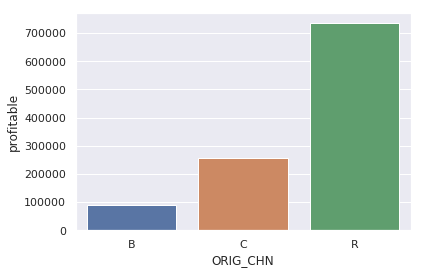

In [40]:
sns.barplot(x="ORIG_CHN", y='profitable', data=df_origchnpd)

### 4.3.2. First Time Home Buyer (FTHB_FLG)

- **First Time Home Buyer**: An indicator that denotes if the borrower or co-borrower qualifies as a first-time homebuyer.
    - Y: Yes
    - N: No
    - U: Unknown

In [41]:
df_fthbflg = df.groupBy('FTHB_FLG').agg(F.sum('profitable').alias('profitable'))

In [42]:
df_fthbflg.show()

+--------+----------+
|FTHB_FLG|profitable|
+--------+----------+
|       Y|     62912|
|       U|         0|
|       N|   1016721|
+--------+----------+



In [43]:
df_fthbflgpd = df_fthbflg.toPandas()

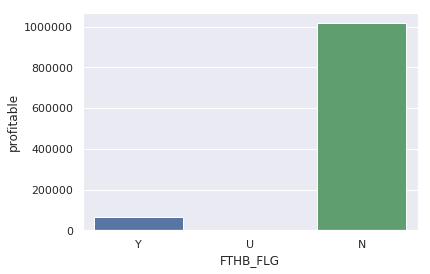

In [44]:
sns.barplot(x="FTHB_FLG", y='profitable', data=df_fthbflgpd)

### 4.3.3. Loan Purpose (PURPOSE)

- **Loan Purpose**: An indicator that denotes whether the mortgage loan is either a refinance mortgage or a purchase money mortgage.
    - P: Purchase
    - C: Cash-out Refinance
    - R: No Cash-out Refinance
    - U: Unknown

In [45]:
df_purpose = df.groupBy('PURPOSE').agg(F.sum('profitable').alias('profitable'))

In [46]:
df_purpose.show()

+-------+----------+
|PURPOSE|profitable|
+-------+----------+
|      U|         0|
|      C|    365911|
|      R|    362962|
|      P|    350760|
+-------+----------+



In [47]:
df_purposepd = df_purpose.toPandas()

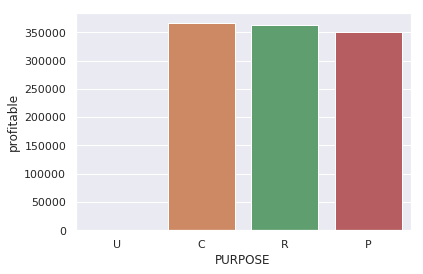

In [48]:
sns.barplot(x="PURPOSE", y='profitable', data=df_purposepd)

### 4.3.4. Occupancy Type (OCC_STAT)

- **Occupancy Type**: An indicator that denotes whether the mortgage loan is secured by a principal residence, second home or investment property.
    - P: Principal
    - S: Second
    - I: Investor

In [49]:
df_occupancy = df.groupBy('OCC_STAT').agg(F.sum('profitable').alias('profitable'))

In [50]:
df_occupancy.show()

+--------+----------+
|OCC_STAT|profitable|
+--------+----------+
|       S|     52297|
|       I|     91715|
|       P|    935621|
+--------+----------+



In [51]:
df_occupancypd = df_occupancy.toPandas()

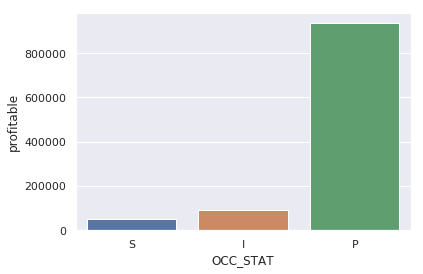

In [52]:
sns.barplot(x='OCC_STAT', y='profitable', data=df_occupancypd)

### 4.3.5. Last Status (LAST_STAT)

- **Last Status**: An indicator that represents the latest status of a loan as available in the dataset
    - C: Current
    - 1: 30 day delinquency
    - 2: 60 day delinquency
    - 3: 90 day delinquency
    - 4: 120 day delinquency
    - 5: 150 day delinquency
    - L: Reperforming Loan Sale
    - N: Note Sale
    - P: Prepaid or Matured
    - R: Repurchased
    - T: Third party sale
    - X: Unknown

In [53]:
df_laststat = df.orderBy('LAST_STAT').groupBy('LAST_STAT').agg(F.sum('profitable').alias('profitable'))

In [54]:
df_laststatpd = df_laststat.toPandas()

In [55]:
df_laststat.groupBy('LAST_STAT').agg(F.sum('profitable').alias('profitable')).orderBy('profitable', ascending = False).show()

+---------+----------+
|LAST_STAT|profitable|
+---------+----------+
|        C|    890350|
|        P|    188510|
|        1|       394|
|        5|       126|
|        R|       104|
|        2|        57|
|        3|        47|
|        4|        41|
|        T|         4|
|        X|         0|
|        L|         0|
|        N|         0|
+---------+----------+



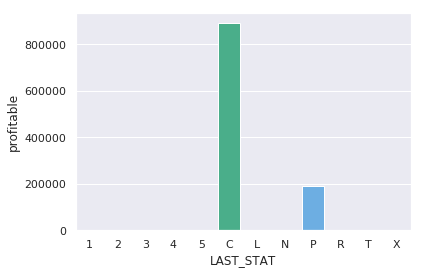

In [56]:
sns.barplot(x='LAST_STAT', y='profitable', data=df_laststatpd)

### 4.3.6. Total Cost (Total_Cost)

***As this is a continuous variable, I will create a bucket from the field in order to aggregate the loans***

In [57]:
df.select('Total_Cost').describe().show()

+-------+------------------+
|summary|        Total_Cost|
+-------+------------------+
|  count|           9362516|
|   mean| 209027.9200940559|
| stddev|116259.53691997674|
|    min|               0.0|
|    max|        1369302.51|
+-------+------------------+



In [58]:
df = df.withColumn('totcostbkt', F.when((F.col('Total_Cost') >= 0) & 
                                           (F.col('Total_Cost') <= 100000), F.lit(1))\
                         .otherwise(F.when((F.col('Total_Cost') > 100000) &
                                           (F.col('Total_Cost') <= 200000), F.lit(2))\
                         .otherwise(F.when((F.col('Total_Cost') > 200000) & 
                                           (F.col('Total_Cost') <= 300000), F.lit(3))\
                         .otherwise(F.when((F.col('Total_Cost') > 300000) & 
                                           (F.col('Total_Cost') <= 500000), F.lit(4))\
                         .otherwise(F.when((F.col('Total_Cost') > 500000), F.lit(5)))))))

In [59]:
df.orderBy('totcostbkt').groupBy('totcostbkt').count().show()

+----------+-------+
|totcostbkt|  count|
+----------+-------+
|         1|1629280|
|         2|3418702|
|         3|2361285|
|         4|1764158|
|         5| 189091|
+----------+-------+



- **Total Cost**: An indicator that denotes the total cost suffered by the lender or investor.
    - 1: 0 to 100000 dollars
    - 2: 100000 to 200000 dollars
    - 3: 200000 to 300000 dollars
    - 4: 300000 to 500000 dollars
    - 5: greater than 500000 dollars

In [60]:
df_totcost = df.orderBy('totcostbkt').groupBy('totcostbkt').agg(F.sum('profitable').alias('profitable'))

In [61]:
df_totcostpd = df_totcost.toPandas()

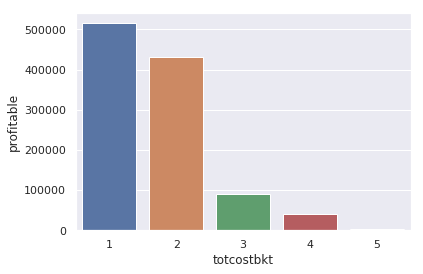

In [62]:
sns.barplot(x='totcostbkt', y='profitable', data=df_totcostpd)

In [63]:
df.write.parquet(temp_combined + '/2/', mode = 'overwrite')

In [9]:
df = spark.read.parquet(temp_combined + '/2/')

# 5. Models

In [10]:
df = df.select('ORIG_CHN',
                 'ORIG_AMT',
                 'OLTV',
                 'OCLTV',
                 'NUM_BO',
                 'DTI',
                 'FTHB_FLG',
                 'PURPOSE',
                 'OCC_STAT',
                 'CSCORE_MN',
                 'LAST_STAT',
                 'NET_SEV',
                 'Total_Cost',
                 'SATO',
                 'profitable')

## IMPORTANT: Handle different fields in different ways 

We have features of at least three kinds:

* __Numeric continuous fields__, which we can use as input to many algorithms as they are. In particular, decision trees can take continuous variables with any value as input, since they only look for the cutoff point that most increases the homogeneity of the resulting groups. In contrast, if we were using a logistic regression with regularization, for example, we would need to first scale the variables to have comparable magnitudes.

* There are fields which we will treat as __categorical variables__, but which are already integers. These need to be __one-hot encoded__.

* Finally, there are several __categorical variables that are encoded as strings__. These need to be one-hot encoded, but __OneHotEncoder__ requires numeric input. Therefore, we will need to apply a __StringIndexer__ to each of them before one-hot encoding.

___PySpark Pipeline___

| Types      |StrIndex   | OneHot   | Model  |
|----------- | --------- | -------- | ----   |
|CAT         | NO        | YES      | YES    |
|STR         | YES       | YES      | YES    |
|CONT        | NO        | NO       | YES    |


***First, I am going to select those field that I previously analyzed that could be useful for the model***

***Then, I am going to analyze the type for later treatment***

In [11]:
df.printSchema()

root
 |-- ORIG_CHN: string (nullable = true)
 |-- ORIG_AMT: integer (nullable = true)
 |-- OLTV: integer (nullable = true)
 |-- OCLTV: integer (nullable = true)
 |-- NUM_BO: integer (nullable = true)
 |-- DTI: double (nullable = true)
 |-- FTHB_FLG: string (nullable = true)
 |-- PURPOSE: string (nullable = true)
 |-- OCC_STAT: string (nullable = true)
 |-- CSCORE_MN: integer (nullable = true)
 |-- LAST_STAT: string (nullable = true)
 |-- NET_SEV: double (nullable = true)
 |-- Total_Cost: double (nullable = true)
 |-- SATO: double (nullable = true)
 |-- profitable: integer (nullable = true)



In [12]:
df.show()

+--------+--------+----+-----+------+----+--------+-------+--------+---------+---------+-------+----------+-----+----------+
|ORIG_CHN|ORIG_AMT|OLTV|OCLTV|NUM_BO| DTI|FTHB_FLG|PURPOSE|OCC_STAT|CSCORE_MN|LAST_STAT|NET_SEV|Total_Cost| SATO|profitable|
+--------+--------+----+-----+------+----+--------+-------+--------+---------+---------+-------+----------+-----+----------+
|       R|  215000|  80|   80|     2|43.0|       N|      P|       S|      728|        C|    1.0| 203093.52| 0.13|         0|
|       R|  112000|  65|   65|     2|35.0|       N|      R|       I|      739|        C|    1.0| 107492.02| 0.63|         0|
|       R|  200000|  57|   57|     2|45.0|       N|      C|       P|      717|        P|    1.0| 182416.51|-0.38|         0|
|       R|  410000|  74|   74|     1|45.0|       N|      C|       P|      666|        1|    1.0| 395172.95| 0.88|         0|
|       R|  242000|  97|   97|     2|42.0|       Y|      P|       P|      789|        C|    1.0| 231017.32|  0.0|         0|


- **14 columns (the profitable field is not counted)**: 
    - 8 continuous variables: it is not necessary to handle these fields for the model.
    - 1 categorical variable: it will be one-hot encoded
    - 5 categorical variables that are encoded as a string: there are two steps, a string indexer and later on one hot encoder

## 5.1. StringIndexer 

A [StringIndexer](https://spark.apache.org/docs/2.2.0/ml-features.html#stringindexer) is an estimator that takes a single string field, then produces a transformer that codifies said field as numeric labels that are fit for feeding to a one-hot encoding. 

We need to specify an input column, an output column, and a way to handle invalids. In this case, invalids are values that the indexer has not seen during fitting but that the transformer finds during processing. Its values are 'error' (the default), which is pretty self-explanatory, 'skip', which drops them, and 'keep', which is what we want. It will assign all unseen labels to a single category index.

In [13]:
string_fields = [field.name for field in df.schema.fields if field.dataType == types.StringType()]

In [14]:
string_fields

['ORIG_CHN', 'FTHB_FLG', 'PURPOSE', 'OCC_STAT', 'LAST_STAT']

In [15]:
string_indexers =[StringIndexer(inputCol=field,outputCol=field+'Index',handleInvalid='keep') for field in string_fields]

In [16]:
for field in string_fields:
    indexer = StringIndexer(inputCol=field, outputCol=field+'Index').fit(df)
    if (field == string_fields[0]):
        df_ind = indexer.transform(df)
    else:
        df_ind = indexer.transform(df_ind)  
df_ind.show()

+--------+--------+----+-----+------+----+--------+-------+--------+---------+---------+-------+----------+-----+----------+-------------+-------------+------------+-------------+--------------+
|ORIG_CHN|ORIG_AMT|OLTV|OCLTV|NUM_BO| DTI|FTHB_FLG|PURPOSE|OCC_STAT|CSCORE_MN|LAST_STAT|NET_SEV|Total_Cost| SATO|profitable|ORIG_CHNIndex|FTHB_FLGIndex|PURPOSEIndex|OCC_STATIndex|LAST_STATIndex|
+--------+--------+----+-----+------+----+--------+-------+--------+---------+---------+-------+----------+-----+----------+-------------+-------------+------------+-------------+--------------+
|       R|  215000|  80|   80|     2|43.0|       N|      P|       S|      728|        C|    1.0| 203093.52| 0.13|         0|          0.0|          0.0|         0.0|          2.0|           0.0|
|       R|  112000|  65|   65|     2|35.0|       N|      R|       I|      739|        C|    1.0| 107492.02| 0.63|         0|          0.0|          0.0|         1.0|          1.0|           0.0|
|       R|  200000|  57| 

## 5.2. OneHotEncoder

A [OneHotEncoder](https://spark.apache.org/docs/2.2.0/ml-features.html#onehotencoder) generates a n-1 length vector column for an n-category column of category indices. 

We need to specify an input and an output column.

One OneHotEncoder per categorical column. We are also going to build these stages programatically

In [17]:
categorical_fields = ['NUM_BO']

In [18]:
encoders_cat =[OneHotEncoder(inputCol=field,outputCol=field+'OneHot') for field in categorical_fields 
                                                                        if field not in string_indexers] 
encoders_str =[OneHotEncoder(inputCol=field+'Index',outputCol=field+'OneHot') for field in string_fields] 

In [19]:
for field in string_fields:
    encoders_str = OneHotEncoder(inputCol=field+'Index',outputCol=field+'OneHot')
    if (field == string_fields[0]):
        df_encdtr= encoders_str.transform(df_ind)
    else:
        df_encdtr = encoders_str.transform(df_encdtr)  
df_encdtr.show()

+--------+--------+----+-----+------+----+--------+-------+--------+---------+---------+-------+----------+-----+----------+-------------+-------------+------------+-------------+--------------+--------------+--------------+-------------+--------------+---------------+
|ORIG_CHN|ORIG_AMT|OLTV|OCLTV|NUM_BO| DTI|FTHB_FLG|PURPOSE|OCC_STAT|CSCORE_MN|LAST_STAT|NET_SEV|Total_Cost| SATO|profitable|ORIG_CHNIndex|FTHB_FLGIndex|PURPOSEIndex|OCC_STATIndex|LAST_STATIndex|ORIG_CHNOneHot|FTHB_FLGOneHot|PURPOSEOneHot|OCC_STATOneHot|LAST_STATOneHot|
+--------+--------+----+-----+------+----+--------+-------+--------+---------+---------+-------+----------+-----+----------+-------------+-------------+------------+-------------+--------------+--------------+--------------+-------------+--------------+---------------+
|       R|  215000|  80|   80|     2|43.0|       N|      P|       S|      728|        C|    1.0| 203093.52| 0.13|         0|          0.0|          0.0|         0.0|          2.0|           

In [20]:
for field in categorical_fields:
    encoders_cat = OneHotEncoder(inputCol=field,outputCol=field+'OneHot')
    if (field == categorical_fields[0]):
        df_enccat= encoders_cat.transform(df_encdtr)
    else:
        df_enccat = encoders_cat.transform(df_enccat)  
df_enccat.show()

+--------+--------+----+-----+------+----+--------+-------+--------+---------+---------+-------+----------+-----+----------+-------------+-------------+------------+-------------+--------------+--------------+--------------+-------------+--------------+---------------+-------------+
|ORIG_CHN|ORIG_AMT|OLTV|OCLTV|NUM_BO| DTI|FTHB_FLG|PURPOSE|OCC_STAT|CSCORE_MN|LAST_STAT|NET_SEV|Total_Cost| SATO|profitable|ORIG_CHNIndex|FTHB_FLGIndex|PURPOSEIndex|OCC_STATIndex|LAST_STATIndex|ORIG_CHNOneHot|FTHB_FLGOneHot|PURPOSEOneHot|OCC_STATOneHot|LAST_STATOneHot| NUM_BOOneHot|
+--------+--------+----+-----+------+----+--------+-------+--------+---------+---------+-------+----------+-----+----------+-------------+-------------+------------+-------------+--------------+--------------+--------------+-------------+--------------+---------------+-------------+
|       R|  215000|  80|   80|     2|43.0|       N|      P|       S|      728|        C|    1.0| 203093.52| 0.13|         0|          0.0|          

## 5.3. VectorAssembler

In [21]:
continuous_fields = ['ORIG_AMT', 'OLTV', 'OCLTV', 'DTI', 'CSCORE_MN', 'NET_SEV', 'Total_Cost', 'SATO']

In [22]:
cols_to_concatenate = [ field + 'OneHot' for field in categorical_fields] + continuous_fields + [field +'OneHot' for field in string_fields]
cols_to_concatenate

['NUM_BOOneHot',
 'ORIG_AMT',
 'OLTV',
 'OCLTV',
 'DTI',
 'CSCORE_MN',
 'NET_SEV',
 'Total_Cost',
 'SATO',
 'ORIG_CHNOneHot',
 'FTHB_FLGOneHot',
 'PURPOSEOneHot',
 'OCC_STATOneHot',
 'LAST_STATOneHot']

In [23]:
assembler = VectorAssembler(inputCols=cols_to_concatenate, outputCol='features')

## 5.4. Train-Split

Now that we have gone to the trouble of building our Pipeline, fitting it and using it to predict the probabilty of delay on unseen data is as easy as using a single Estimator:

In [24]:
df_transform = df_enccat.select(cols_to_concatenate + ['profitable'])

In [25]:
df_transform.write.parquet(temp_combined + '/3/', mode = 'overwrite')

In [26]:
df_transform = spark.read.parquet(temp_combined + '/3/')

In [27]:
(df_train, df_test) = df_transform.randomSplit([0.8, 0.2],seed = 11)

In [28]:
df_train.count()

7489680

In [29]:
df_test.count()

1872836

## 5.5. Random Forest Classifier

In [30]:
rf = RandomForestClassifier(featuresCol='features', labelCol='profitable')

### 5.5.1. Pipeline

Now that we have all the stages, we are finally ready to put them together into a single Estimator, our Pipeline.

In [31]:
pipeline = Pipeline(stages= [assembler,rf])

In [33]:
params = paramGrid = ParamGridBuilder().build()

In [34]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=params,
                          evaluator=MulticlassClassificationEvaluator(labelCol='profitable'),
                          numFolds=5)

In [35]:
model = crossval.fit(df_train)

In [36]:
bestModel = model.bestModel

### 5.5.2. Evaluating the model

In [39]:
tunedprediction = bestModel.transform(df_test)

In [40]:
evaluator = MulticlassClassificationEvaluator(labelCol="profitable", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(tunedprediction)
print("accuracy of RandomForest is = %g"% (accuracy))
print("Test Error of RandomForest = %g " % (1.0 - accuracy))

accuracy of RandomForest is = 0.942973
Test Error of RandomForest = 0.0570269 


In [41]:
expected = tunedprediction.select(['profitable']).collect()
predicted = tunedprediction.select(['prediction']).collect()

print(classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97   1656396
           1       0.89      0.58      0.70    216650

    accuracy                           0.94   1873046
   macro avg       0.92      0.79      0.84   1873046
weighted avg       0.94      0.94      0.94   1873046



In [42]:
# Confusion matrix
print(metrics.confusion_matrix(expected, predicted))

[[1640351   16045]
 [  90769  125881]]


### 5.5.3. Feature Importance

In [43]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [45]:
ExtractFeatureImp(bestModel.stages[-1].featureImportances, tunedprediction, "features").head(10)

,idx,name,score
30,10,OCLTV,0.336976
29,9,OLTV,0.268246
28,8,ORIG_AMT,0.115159
34,14,Total_Cost,0.075202
32,12,CSCORE_MN,0.055333
35,15,SATO,0.054906
31,11,DTI,0.050355
12,20,PURPOSEOneHot_P,0.009083
17,25,LAST_STATOneHot_C,0.007471
11,19,FTHB_FLGOneHot_Y,0.006758


In [46]:
most_important_features = list(ExtractFeatureImp(bestModel.stages[-1].featureImportances, tunedprediction, "features")['name'].head(10))

In [47]:
best_scores = list(ExtractFeatureImp(bestModel.stages[-1].featureImportances, tunedprediction, "features")['score'].head(10))

In [48]:
x_values = list(range(11)[1:11])

In [49]:
plt.rcParams['figure.figsize'] = (20, 8)

Text(0.5, 1.0, 'Feature Importances')

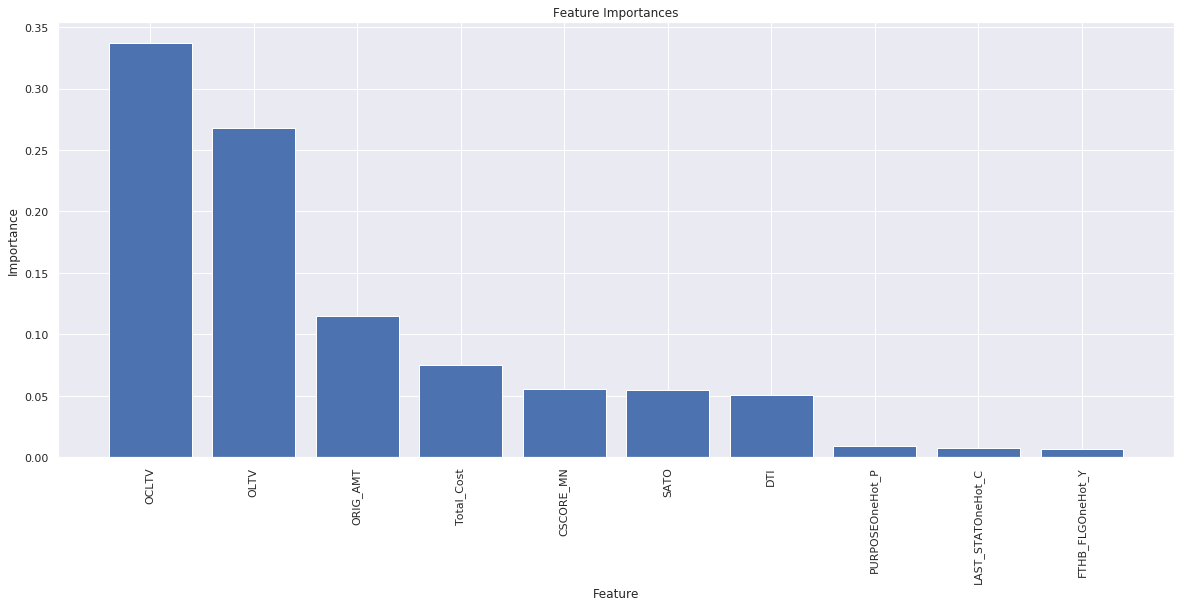

In [50]:
plt.bar(x_values, best_scores, orientation = 'vertical')
plt.xticks(x_values, most_important_features, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

## 5.6. Decision Tree Classifier

In [51]:
dt = DecisionTreeClassifier(featuresCol='features', labelCol='profitable')

### 5.6.1. Pipeline

Now that we have all the stages, we are finally ready to put them together into a single Estimator, our Pipeline.

In [52]:
pipeline = Pipeline(stages= [assembler,dt])

In [54]:
params = paramGrid = ParamGridBuilder().build()

In [55]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=params,
                          evaluator=MulticlassClassificationEvaluator(labelCol='profitable'),
                          numFolds=5)

In [56]:
model = crossval.fit(df_train)

In [57]:
bestModel = model.bestModel

### 5.6.2. Evaluating the model

In [58]:
tunedprediction = bestModel.transform(df_test)

In [59]:
evaluator = MulticlassClassificationEvaluator(labelCol="profitable", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(tunedprediction)
print("Accuracy of DecisionTree is = %g"% (accuracy))
print("Test Error of DecisionTree = %g " % (1.0 - accuracy))

Accuracy of DecisionTree is = 0.952215
Test Error of DecisionTree = 0.0477847 


In [60]:
expected = tunedprediction.select(['profitable']).collect()
predicted = tunedprediction.select(['prediction']).collect()

print(classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97   1656396
           1       0.81      0.77      0.79    216650

    accuracy                           0.95   1873046
   macro avg       0.89      0.87      0.88   1873046
weighted avg       0.95      0.95      0.95   1873046



In [61]:
# Confusion matrix
print(metrics.confusion_matrix(expected, predicted))

[[1616802   39594]
 [  49909  166741]]


### 5.6.3. Feature Importance

In [62]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [63]:
ExtractFeatureImp(bestModel.stages[-1].featureImportances, tunedprediction, "features").head(10)

,idx,name,score
30,10,OCLTV,0.549121
28,8,ORIG_AMT,0.171700
31,11,DTI,0.142987
32,12,CSCORE_MN,0.117318
34,14,Total_Cost,0.014506
29,9,OLTV,0.004322
35,15,SATO,0.000047
24,32,LAST_STATOneHot_R,0.000000
20,28,LAST_STATOneHot_5,0.000000
21,29,LAST_STATOneHot_2,0.000000


In [64]:
most_important_features = list(ExtractFeatureImp(bestModel.stages[-1].featureImportances, tunedprediction, "features")['name'].head(10))

In [65]:
best_scores = list(ExtractFeatureImp(bestModel.stages[-1].featureImportances, tunedprediction, "features")['score'].head(10))

In [66]:
x_values = list(range(11)[1:11])

In [67]:
plt.rcParams['figure.figsize'] = (20, 8)

Text(0.5, 1.0, 'Feature Importances')

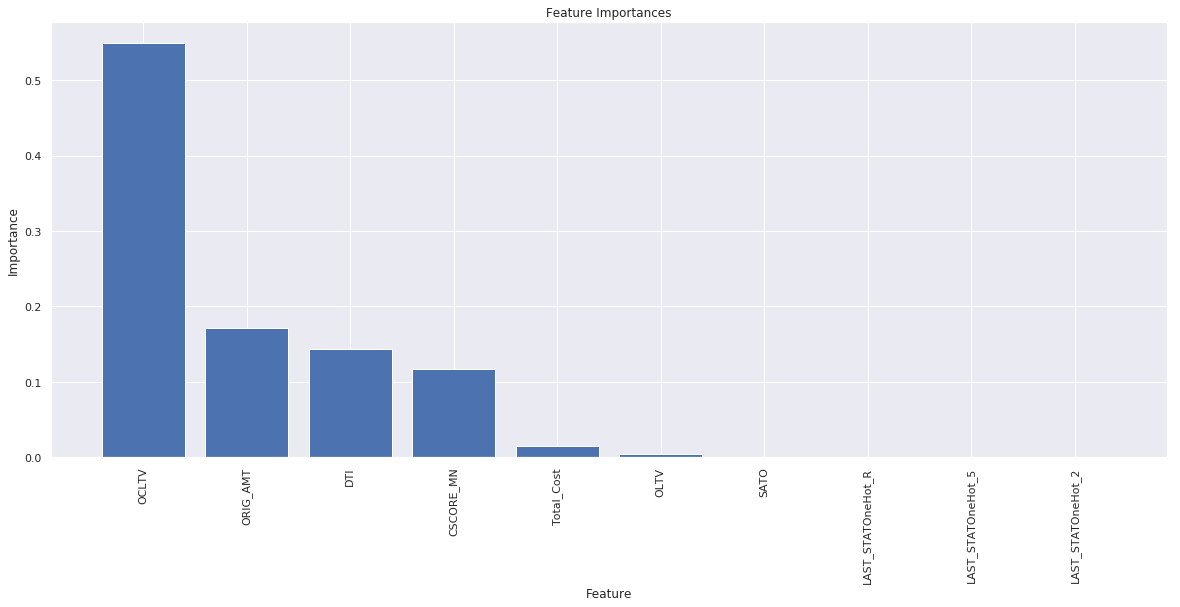

In [68]:
plt.bar(x_values, best_scores, orientation = 'vertical')
plt.xticks(x_values, most_important_features, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

Now that we have gone to the trouble of building our Pipeline, fitting it and using it to predict the probabilty of delay on unseen data is as easy as using Cross Validation:

## 5.7. Logistic Regression

In [69]:
lr = LogisticRegression(featuresCol='features', labelCol='profitable')

### 5.7.1. Pipeline

Now that we have all the stages, we are finally ready to put them together into a single Estimator, our Pipeline.

In [70]:
pipeline = Pipeline(stages= [assembler,lr])

In [72]:
params = paramGrid = ParamGridBuilder().build()

In [73]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=params,
                          evaluator=MulticlassClassificationEvaluator(labelCol='profitable'),
                          numFolds=5)

In [74]:
model = crossval.fit(df_train)

In [75]:
bestModel = model.bestModel

### 5.7.2. Evaluating the model

In [76]:
tunedprediction = bestModel.transform(df_test)

In [77]:
evaluator = MulticlassClassificationEvaluator(labelCol="profitable", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(tunedprediction)
print("accuracy of LogisticRegression is = %g"% (accuracy))
print("Test Error of LogisticRegression = %g " % (1.0 - accuracy))

accuracy of LogisticRegression is = 0.930346
Test Error of LogisticRegression = 0.0696545 


In [78]:
expected = tunedprediction.select(['profitable']).collect()
predicted = tunedprediction.select(['prediction']).collect()

print(classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96   1656396
           1       0.75      0.59      0.66    216650

    accuracy                           0.93   1873046
   macro avg       0.85      0.78      0.81   1873046
weighted avg       0.93      0.93      0.93   1873046



In [79]:
# Confusion matrix
print(metrics.confusion_matrix(expected, predicted))

[[1614557   41839]
 [  88627  128023]]


## 5.8. Gradient Boosting Classifier

In [80]:
gbt = GBTClassifier(featuresCol='features', labelCol='profitable')

### 5.8.1. Pipeline

Now that we have all the stages, we are finally ready to put them together into a single Estimator, our Pipeline.

In [81]:
pipeline = Pipeline(stages= [assembler,gbt])

In [83]:
params = paramGrid = ParamGridBuilder().build()

In [84]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=params,
                          evaluator=MulticlassClassificationEvaluator(labelCol='profitable'),
                          numFolds=5)

In [85]:
model = crossval.fit(df_train)

In [86]:
bestModel = model.bestModel

### 5.8.2. Evaluating the model

In [87]:
tunedprediction = bestModel.transform(df_test)

In [88]:
evaluator = MulticlassClassificationEvaluator(labelCol="profitable", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(tunedprediction)
print("Accuracy of GBTClassifier is = %g"% (accuracy))
print("Test Error of GBTClassifier = %g " % (1.0 - accuracy))

Accuracy of DecisionTree is = 0.965434
Test Error of DecisionTree = 0.0345662 


In [89]:
expected = tunedprediction.select(['profitable']).collect()
predicted = tunedprediction.select(['prediction']).collect()

print(classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98   1656396
           1       0.90      0.79      0.84    216650

    accuracy                           0.97   1873046
   macro avg       0.94      0.89      0.91   1873046
weighted avg       0.96      0.97      0.96   1873046



In [90]:
# Confusion matrix
print(metrics.confusion_matrix(expected, predicted))

[[1638120   18276]
 [  46468  170182]]


### 5.8.3. Feature Importance

In [91]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [92]:
ExtractFeatureImp(bestModel.stages[-1].featureImportances, tunedprediction, "features").head(10)

,idx,name,score
30,10,OCLTV,0.235263
28,8,ORIG_AMT,0.185835
31,11,DTI,0.177391
32,12,CSCORE_MN,0.131474
29,9,OLTV,0.077001
35,15,SATO,0.066500
1,1,NUM_BOOneHot_1,0.053728
17,25,LAST_STATOneHot_C,0.042256
34,14,Total_Cost,0.028378
18,26,LAST_STATOneHot_P,0.002168


In [93]:
most_important_features = list(ExtractFeatureImp(bestModel.stages[-1].featureImportances, tunedprediction, "features")['name'].head(10))

In [94]:
best_scores = list(ExtractFeatureImp(bestModel.stages[-1].featureImportances, tunedprediction, "features")['score'].head(10))

In [95]:
x_values = list(range(11)[1:11])

In [96]:
plt.rcParams['figure.figsize'] = (20, 8)

Text(0.5, 1.0, 'Feature Importances')

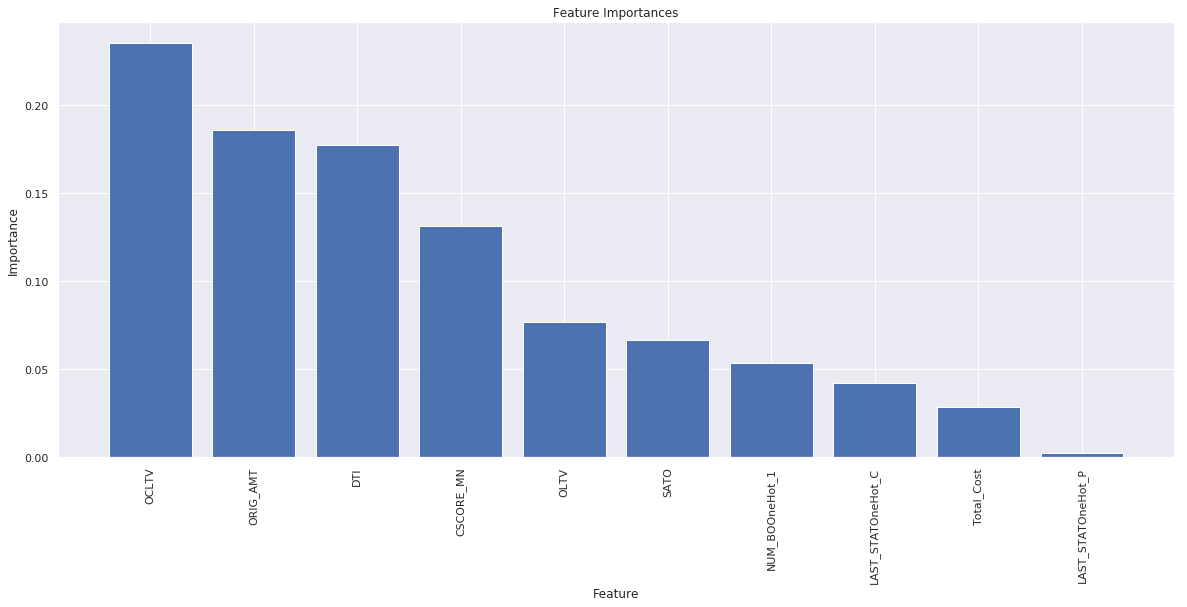

In [97]:
plt.bar(x_values, best_scores, orientation = 'vertical')
plt.xticks(x_values, most_important_features, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

### 5.8.4. Parameter Tuning

In [35]:
new_cols = ['OCLTV',
            'ORIG_AMT',
            'DTI',
            'CSCORE_MN',
            'OLTV',
            'SATO',
            'NUM_BOOneHot',
            'LAST_STAT',
            'Total_Cost']

In [36]:
assembler = VectorAssembler(inputCols=new_cols, outputCol='features')

In [37]:
gbt = GBTClassifier(featuresCol='features', labelCol='profitable')

In [38]:
pipeline = Pipeline(stages= [assembler,gbt])

#### 5.8.4.1. Pipeline

Now that we have all the stages, we are finally ready to put them together into a single Estimator, our Pipeline.

In [39]:
params = ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build()

In [40]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=params,
                          evaluator=MulticlassClassificationEvaluator(labelCol='profitable'),
                          numFolds=5)

In [41]:
model = crossval.fit(df_train)

In [42]:
bestModel = model.bestModel

#### 5.8.4.2. Re-evaluating the model

In [43]:
tunedprediction = bestModel.transform(df_test)

In [44]:
evaluator = MulticlassClassificationEvaluator(labelCol="profitable", predictionCol="prediction", metricName="accuracy")

accuracy = evaluator.evaluate(tunedprediction)
print("Accuracy of GBTClassifier is = %g"% (accuracy))
print("Test Error of GBTClassifier = %g " % (1.0 - accuracy))

Accuracy of DecisionTree is = 0.977994
Test Error of DecisionTree = 0.0220062 


In [45]:
expected = tunedprediction.select(['profitable']).collect()
predicted = tunedprediction.select(['prediction']).collect()

print(classification_report(expected, predicted))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99   1656307
           1       0.93      0.88      0.90    216529

    accuracy                           0.98   1872836
   macro avg       0.96      0.93      0.94   1872836
weighted avg       0.98      0.98      0.98   1872836



In [46]:
# Confusion matrix
print(metrics.confusion_matrix(expected, predicted))

[[1641429   14878]
 [  26336  190193]]


In [48]:
print ('The percentage of errors found for the system is' , round((14878+26336)*100/(1641429+190193), 2))

The percentage of errors found for the system is 2.25
